# Connecting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/MyDrive/Code/Tutorials/CNN/transfer_learning")

In [3]:
!ls

AlienVsPredator2.ipynb	AlienVsPredator.ipynb


# Data

In [ ]:
!pip install kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pmigdal/alien-vs-predator-images

 85% 12.0M/14.1M [00:00<00:00, 34.6MB/s]
100% 14.1M/14.1M [00:00<00:00, 39.1MB/s]


In [ ]:
import zipfile
zf = "/content/drive/MyDrive/Code/Tutorials/CNN/transfer_learning/alien-vs-predator-images.zip"
target_dir = "/content/drive/MyDrive/Code/Tutorials/datasets"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# Initialize

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


base_dir = '/content/drive/MyDrive/Code/Tutorials/datasets/alien_vs_predator_thumbnails/data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 8 

IMG_HEIGHT = 224
IMG_WIDTH = 224

epochs = 100

# Prepearing the Image

## Loading the Images

In [5]:
train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            label_mode="binary",
                                            color_mode='rgb',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH))

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  label_mode="binary",
                                                  color_mode='rgb',
                                                  image_size=(IMG_HEIGHT, IMG_WIDTH))

class_names = train_dataset.class_names
print(class_names)

Found 694 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
['alien', 'predator']


## Visualize the Images

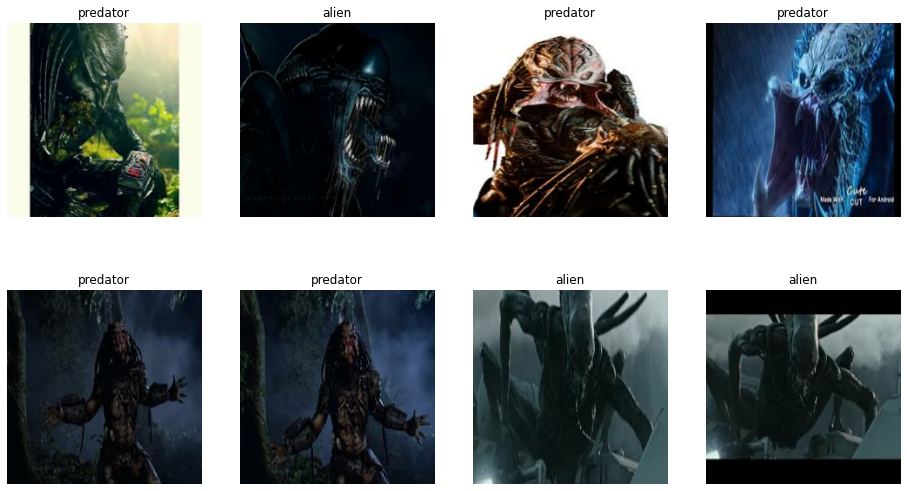

In [ ]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

## Image Augmentation

In [6]:
data_augmentation = Sequential(
  [
    RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), mode="horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
  ]
  , name="Augmentation"
)

In [ ]:
data_augmentation.summary()

Model: "Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


## Create Test Dataset

In [7]:
# test veriseti olusturduk
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)  # valid in %20 sini test e tasidik
validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


## Improvement in Datasets

In [9]:
# read-train zamanlarini senkronize ederek max verimi almamizi sagliyor
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# cache() # caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)
# shuffle() # shuffle the samples to have always a random order of samples fed to the network

## Visualize Orijinal and Augmented Images

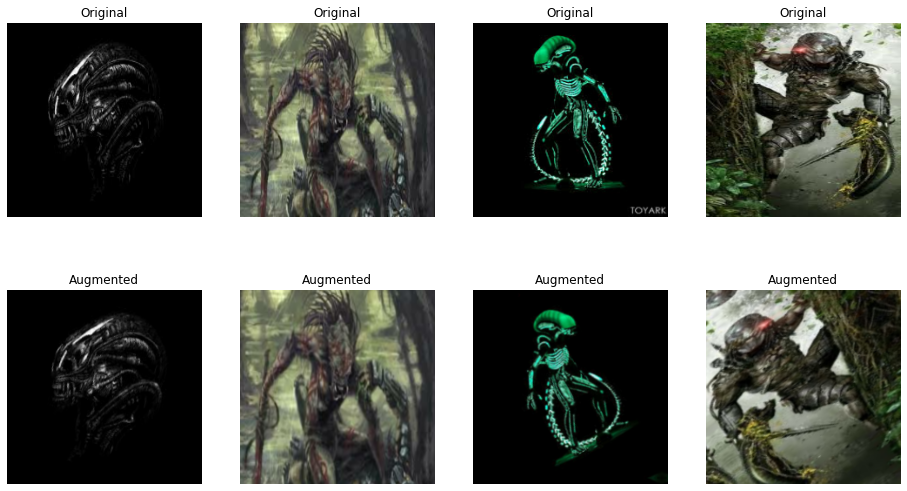

In [ ]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    argImg = data_augmentation(images)
    for i in range(int(BATCH_SIZE/2)):
       
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i + 1 + int(BATCH_SIZE/2))
        plt.imshow(argImg[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

# Model

## Necessary imports

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import math

## CNN Architecture

In [11]:
base_densenet_model = Sequential([
                        Rescaling(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), scale=1.0/255, name="Rescailing"),
                        data_augmentation,
                        DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), weights="imagenet", include_top=False)
], name="base_densenet_model")

base_densenet_model.trainable = False
base_densenet_model.summary()


custom_densenet_model = Sequential([
        base_densenet_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid")
        ], name = "custom_densenet_model")

custom_densenet_model.summary()

74850304/74836368 [==============================] - 1s 0us/step
Model: "base_densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescailing (Rescaling)      (None, 224, 224, 3)       0         
                                                                 
 Augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
Total params: 18,321,984
Trainable params: 0
Non-trainable params: 18,321,984
_________________________________________________________________
Model: "custom_densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_densenet_model (Sequen  (None, 7, 7, 1920)       18321984  
 tial

In [12]:
custom_densenet_model.compile(optimizer=Adam(learning_rate=0.001*3),
                         loss=BinaryCrossentropy(from_logits=False),
                         metrics=['accuracy']
                         )

## Fit the Model

In [13]:
# early stopping to monitor the validation loss and avoid overfitting
early = EarlyStopping(monitor="val_loss", 
                      patience=math.floor(epochs*0.1))

# ReduceLROnPlateau to stabilize the training process of the model
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.3,
                                            min_lr=0.000001)
# saves the model in the current directory as the best validation accuracy is achieved.
modelcheck = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [14]:
history = custom_densenet_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[modelcheck, learning_rate_reduction, early],
  verbose=1
)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.4018 - accuracy: 0.8012
Epoch 00001: val_accuracy improved from -inf to 0.90625, saving model to best_model.hdf5
87/87 [==============================] - 270s 1s/step - loss: 0.4018 - accuracy: 0.8012 - val_loss: 0.2373 - val_accuracy: 0.9062 - lr: 0.0030
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9020
Epoch 00002: val_accuracy improved from 0.90625 to 0.93125, saving model to best_model.hdf5
87/87 [==============================] - 17s 192ms/step - loss: 0.2262 - accuracy: 0.9020 - val_loss: 0.1875 - val_accuracy: 0.9312 - lr: 0.0030
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9294
Epoch 00003: val_accuracy did not improve from 0.93125
87/87 [==============================] - 13s 155ms/step - loss: 0.1950 - accuracy: 0.9294 - val_loss: 0.1902 - val_accuracy: 0.9312 - lr: 0.0030
Epoch 4/100
87/87 [===========================

## Evaluate

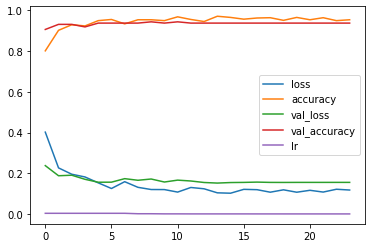

In [15]:
pd.DataFrame(custom_densenet_model.history.history).plot()

In [16]:
test_accu = custom_densenet_model.evaluate(test_dataset)

print("The testing accuracy is : ", test_accu[1]*100, "%")

5/5 [==============================] - 1s 137ms/step - loss: 0.2416 - accuracy: 0.9000
The testing accuracy is :  89.99999761581421 %


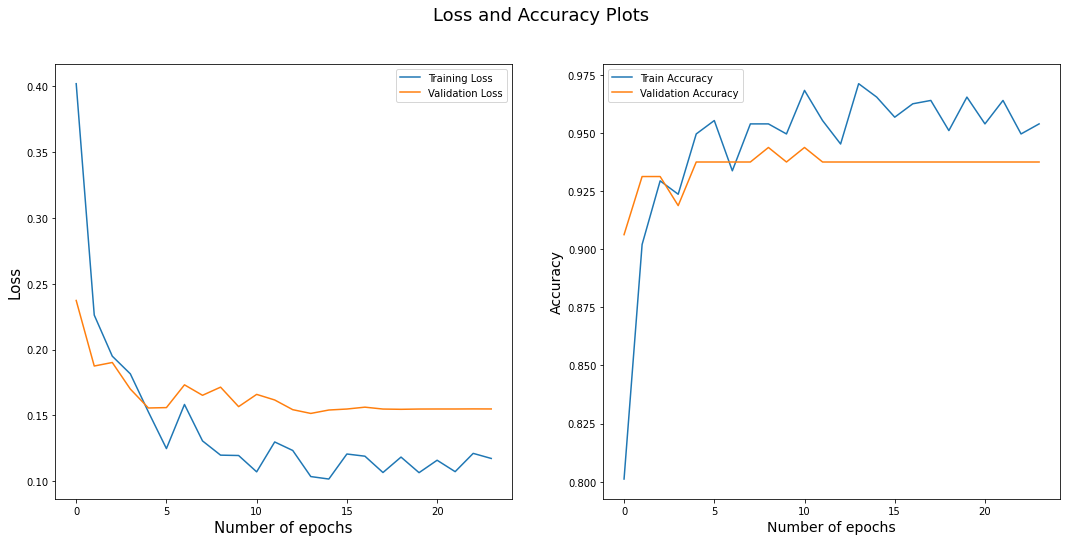

In [17]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()